In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from sklearn.metrics import r2_score, mean_absolute_error as mae, mean_absolute_percentage_error as mape

In [2]:
# read in csvs
def prep_df(file): # path: eg. "nn_pred_data.pkl"
    print(file)
    data_path = "/data/workspace_files/"
    full_df = pd.read_pickle(data_path + file)
    full_df['S/K'] = full_df['S'] / full_df['K']
    full_df = full_df.reindex([full_df.columns.tolist()[-1]]+full_df.columns.tolist()[:-1], axis=1)

    train_df = full_df[full_df['is_train'] == True]
    test_df = full_df[full_df['is_train'] == False]

    print(train_df.shape)
    print(test_df.shape)
    return train_df, test_df


base_trn, base_tst = prep_df("nn_pred_data.pkl")
new_trn, new_tst = prep_df("nn_pred_data_30patience.pkl")

nn_pred_data.pkl
(25920, 13)
(38880, 13)
nn_pred_data_30patience.pkl
(25920, 13)
(38880, 13)


In [3]:
def mapeerror(output, target):
    return np.mean(np.abs(output - target) / np.abs(target))

def maxerror(output, target):
    return np.max(np.abs(output - target))

def mixederror(output, target):
    return mapeerror(output, target) + maxerror(output, target)

def print_basic_metrics(train, test, mode):
    test = test.copy()
    print(f'mode: {mode}')
    # basic metrics:
    metrics_func_dict = {"mae": mae, "mape": mapeerror, "max": maxerror, "mixed": mixederror}
    for key, func in metrics_func_dict.items():
        print(f"{key}: train : {func(train[mode], train['Lognormal_vol'])}, test : {func(test[mode], test['Lognormal_vol'])}")

def absolute_error_analysis(output, mode, quantile=0.95):
    # absolute difference
    output['diff'] = np.abs(output['Lognormal_vol'] - output[mode])
    print(f'absolute difference: test')
    print(output['diff'].describe())

    # max location
    print(f'{quantile * 100}th quantile absolute error distribution (normalized by sampling): test')
    limit = output['diff'].quantile(quantile)
    outliers = output[output['diff'] >= limit]

    S_K = outliers['S/K'].value_counts() / output['S/K'].value_counts()
    plt.plot(S_K.index, S_K.fillna(0))
    for col in ['T', 'V_atm', 'Beta', 'Rho', 'Volvol']:
        print(f"\n{col}: ")
        ratio = outliers[col].value_counts() / output[col].value_counts()
        print( ratio.fillna(0) ) # % of outliers with this col
    return output['diff']

In [8]:
base_trn[''].describe()

,S/K,S,T,V_atm,Beta,Rho,Volvol,K,Lognormal_vol,pred_mapeloss,pred_maxloss,pred_mixedloss
count,25920.000000,25920.000000,25920.000000,25920.000000,25920.000000,25920.000000,25920.000000,25920.000000,25920.000000,25920.000000,25920.000000,25920.000000
mean,2.052840,0.052677,10.253009,0.007977,0.399560,0.001728,0.249057,0.052917,0.174176,0.169766,0.251360,0.172290
std,3.263347,0.029741,6.874312,0.005729,0.300005,0.327186,0.176997,0.029767,0.365159,0.356391,0.353221,0.367447
min,0.050000,0.005000,0.500000,0.001000,0.100000,-0.400000,0.000100,0.005000,0.004975,0.005316,-0.057283,0.005019
25%,0.527363,0.030909,5.375000,0.001000,0.100000,-0.400000,0.125075,0.030909,0.009706,0.009450,0.062086,0.008963
50%,1.000000,0.056818,10.250000,0.008000,0.100000,0.000000,0.250050,0.056818,0.034979,0.035007,0.168364,0.034311
75%,1.896226,0.082727,15.125000,0.015000,0.700000,0.400000,0.375025,0.082727,0.128913,0.121284,0.259374,0.122560
max,20.000000,0.100000,20.000000,0.015000,0.700000,0.400000,0.500000,0.100000,1.387807,1.278923,1.343452,1.393796


In [4]:
for mode in ['pred_mapeloss', 'pred_maxloss', 'pred_mixedloss']:
    print('base')
    print_basic_metrics(base_trn, base_tst, mode)
    print('30 patience')
    print_basic_metrics(new_trn, new_tst, mode)
    print('\n')

base
mode: pred_mapeloss
mae: train : 0.005640919777674426, test : 0.005869179089933592
mape: train : 0.03587095400624075, test : 0.03583260140391722
max: train : 0.13367372350196538, test : 0.13226170763125555
mixed: train : 0.16954467750820612, test : 0.16809430903517278
30 patience
mode: pred_mapeloss
mae: train : 0.005576053333176417, test : 0.0058348014056127445
mape: train : 0.028289112170992843, test : 0.02831884553519941
max: train : 0.15154176549415288, test : 0.15559293545123842
mixed: train : 0.17983087766514572, test : 0.18391178098643784


base
mode: pred_maxloss
mae: train : 0.09200417817966396, test : 0.09117057931730609
mape: train : 4.63612795094538, test : 4.581172780872611
max: train : 0.232012500550224, test : 0.23189287553855784
mixed: train : 4.868140451495604, test : 4.813065656411168
30 patience
mode: pred_maxloss
mae: train : 0.017559521291549262, test : 0.01763824750058215
mape: train : 1.0585845725820298, test : 1.0715529787849798
max: train : 0.0735485932582

In [9]:
0.06 * 0.17

0.0102

base
absolute difference: test
count    3.888000e+04
mean     5.869179e-03
std      1.564753e-02
min      1.431759e-08
25%      3.676969e-04
50%      1.074106e-03
75%      2.977201e-03
max      1.322617e-01
Name: diff, dtype: float64
95.0th quantile absolute error distribution (normalized by sampling): test

T: 
0.500     0.247706
5.375     0.000000
10.250    0.000000
15.125    0.000000
20.000    0.000000
Name: T, dtype: float64

V_atm: 
0.001    0.051565
0.008    0.048010
0.015    0.050447
Name: V_atm, dtype: float64

Beta: 
0.1    0.000000
0.7    0.099902
Name: Beta, dtype: float64

Rho: 
-0.4    0.050058
 0.0    0.049455
 0.4    0.050493
Name: Rho, dtype: float64

Volvol: 
0.000100    0.053868
0.125075    0.049749
0.250050    0.049648
0.375025    0.048771
0.500000    0.048009
Name: Volvol, dtype: float64


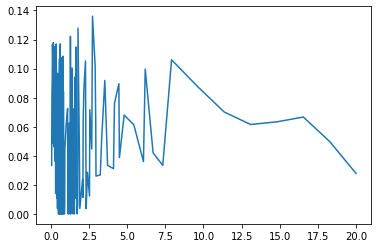

In [5]:
print('base')
base_outliers = absolute_error_analysis(base_tst, 'pred_mapeloss', quantile=0.95)

30 patience
absolute difference: test
count    3.888000e+04
mean     5.834801e-03
std      1.633917e-02
min      1.221122e-10
25%      2.642769e-04
50%      1.063990e-03
75%      3.776797e-03
max      1.555929e-01
Name: diff, dtype: float64
95.0th quantile absolute error distribution (normalized by sampling): test

T: 
0.500     0.247706
5.375     0.000000
10.250    0.000000
15.125    0.000000
20.000    0.000000
Name: T, dtype: float64

V_atm: 
0.001    0.048924
0.008    0.049314
0.015    0.051759
Name: V_atm, dtype: float64

Beta: 
0.1    0.000000
0.7    0.099902
Name: Beta, dtype: float64

Rho: 
-0.4    0.052830
 0.0    0.044540
 0.4    0.052668
Name: Rho, dtype: float64

Volvol: 
0.000100    0.051272
0.125075    0.047950
0.250050    0.048241
0.375025    0.049414
0.500000    0.053130
Name: Volvol, dtype: float64


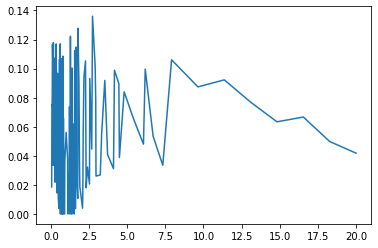

In [6]:
print('30 patience')
new_outliers = absolute_error_analysis(new_tst, 'pred_mapeloss', quantile=0.95)

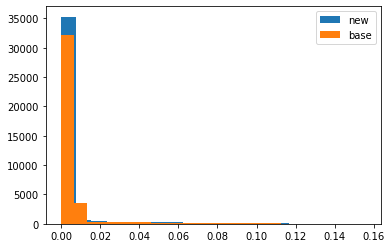

In [7]:
plt.hist(new_outliers, 20, alpha=1, label='new')
plt.hist(base_outliers, 20, alpha=1, label='base')

plt.legend(loc='upper right')
plt.show()